# T5 NusaX-MT Javanese-Sundanese Machine Translation

---




Translation converts a sequence of text from one language to another. It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts, but it can also be used for speech or some combination in between like text-to-speech or speech-to-text.


Before you begin, make sure you have all the necessary libraries installed:

# Install & Import Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 947.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 3.7 MB/s eta 0:00:00


In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


# Load Datasets

Start by loading the Full NusaX datasets and Sundanese to English NusaX SubDataset

In [3]:
nusax_mt = load_dataset("indonlp/NusaX-MT")
nusax_jav_sun = load_dataset("indonlp/NusaX-MT", name='jav-sun')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

# Exploratory Datasets Analysis

Before using the datasets we should do some Exploratory to gain more information about the datasets

In [ ]:
display(nusax_mt)
display(nusax_jav_sun)

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [4]:
nusax_mt_df_train = nusax_mt['train'].to_pandas()
nusax_mt_df_test = nusax_mt['test'].to_pandas()
nusax_mt_df_valid = nusax_mt['validation'].to_pandas()

nusax_jav_sun_df_train = nusax_jav_sun['train'].to_pandas()
nusax_jav_sun_df_test = nusax_jav_sun['test'].to_pandas()
nusax_jav_sun_df_valid = nusax_jav_sun['validation'].to_pandas()

In [5]:
display(nusax_mt_df_train)
print('#'*100)
display(nusax_jav_sun_df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
65995,65995,Si A pangkataionna tong kosong nyaring bunyina...,Si A nyarita tong kosong heuras bunyina bicara...,bbc,sun
65996,65996,Sambalna dang nahaluluan di inganan na asing. ...,Sambelna moal aya di tempat nu sanes. Rasa tar...,bbc,sun
65997,65997,"Pandapothu lumayan do hu lala steak nai, alai ...","Numutkeun abdi steakna cekap raos, mung leuwih...",bbc,sun
65998,65998,radotu sipanganon on dah gus na lagi musim na ...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,bbc,sun


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,jav,sun
1,1,Roti-roti sing disajekne nggarai aku nostalgia...,Kue anu disajikeun ngajantenkeun kuring nostal...,jav,sun
2,2,Ibu uwis tahu kerja ing grab indonesia,Ibu kantos ngadamel di grab indonesia,jav,sun
3,3,Paling seneng banget mangan awan ing kene pith...,Pang resepna tuang beubeurangan di dieu hayam ...,jav,sun
4,4,Pelayanane bis DAMRI apik banget.,Palayanan beus DAMRI sae pisan,jav,sun
...,...,...,...,...,...
495,495,Si A omonge tong kosong banter unine ngomong o...,Si A nyarita tong kosong heuras bunyina bicara...,jav,sun
496,496,Sambele ora bakal ana ing panggonan liya. Rasa...,Sambelna moal aya di tempat nu sanes. Rasa tar...,jav,sun
497,497,"Miturutku stike cukup enak, mung luwah apik pe...","Numutkeun abdi steakna cekap raos, mung leuwih...",jav,sun
498,498,Dijaga ya mangane gus pancen lagi musime saiki...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,jav,sun


### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly

In [6]:
jav_sun_df = pd.concat(
    [
        nusax_jav_sun_df_train,
        nusax_jav_sun_df_test,
        nusax_jav_sun_df_valid
    ],
    axis=0,
    ignore_index=True
    )

nusax_full_df = pd.concat(
    [
        nusax_mt_df_train,
        nusax_mt_df_test,
        nusax_mt_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(jav_sun_df)
print('#'*100)
display(nusax_full_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,jav,sun
1,1,Roti-roti sing disajekne nggarai aku nostalgia...,Kue anu disajikeun ngajantenkeun kuring nostal...,jav,sun
2,2,Ibu uwis tahu kerja ing grab indonesia,Ibu kantos ngadamel di grab indonesia,jav,sun
3,3,Paling seneng banget mangan awan ing kene pith...,Pang resepna tuang beubeurangan di dieu hayam ...,jav,sun
4,4,Pelayanane bis DAMRI apik banget.,Palayanan beus DAMRI sae pisan,jav,sun
...,...,...,...,...,...
995,95,Tolong infoake atm nang ndi wae ing semarang s...,Mohon informasikeun atm mana wae di semarang n...,jav,sun
996,96,Kanca ngrekomendasikake panggonan iki amarga r...,Rerencangan nyarankeun tempat ieu kusabab rasa...,jav,sun
997,97,"Kaping pisa mara mrene aku nyepelake, pas wekt...","Mimiti kuring kadieu nganggap enteng, sawaktos...",jav,sun
998,98,Panggonane nyenengake kanggo sing uwis kaluwar...,Tempatna nyenengkeun nya kanggo nu atos berkul...,jav,sun


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
131995,13195,Tolong jolo paboa atm na didia do di semarang ...,Mohon informasikeun atm mana wae di semarang n...,bbc,sun
131996,13196,Dongan mangarekomendasihon inganan on alani da...,Rerencangan nyarankeun tempat ieu kusabab rasa...,bbc,sun
131997,13197,Parjolo sahali au ro tuson dang apala lomo roh...,"Mimiti kuring kadieu nganggap enteng, sawaktos...",bbc,sun
131998,13198,"Inganan na tabo, denggan laho tu akka naung ma...",Tempatna nyenengkeun nya kanggo nu atos berkul...,bbc,sun


### Setences Length

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length

In [7]:
nusax_full_df['text_1_length'] = nusax_full_df['text_1'].apply(lambda x: len(x.split()))
nusax_full_df['text_2_length'] = nusax_full_df['text_2'].apply(lambda x: len(x.split()))
jav_sun_df['text_1_length'] = jav_sun_df['text_1'].apply(lambda x: len(x.split()))
jav_sun_df['text_2_length'] = jav_sun_df['text_2'].apply(lambda x: len(x.split()))

display(nusax_full_df.describe())
display(jav_sun_df.describe())

,text_1_length,text_2_length
count,132000.000000,132000.000000
mean,24.171417,24.171417
std,15.180737,15.180737
min,1.000000,1.000000
25%,13.000000,13.000000
50%,20.000000,20.000000
75%,32.000000,32.000000
max,107.000000,107.000000


,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.058000,23.098000
std,14.318158,14.290298
min,4.000000,1.000000
25%,12.000000,12.000000
50%,19.000000,19.000000
75%,31.000000,31.000000
max,76.000000,76.000000


### Check Languages Distribution

After that we also need to check the languages distribution, we can use library Matplotlib and Seaborn to do that.

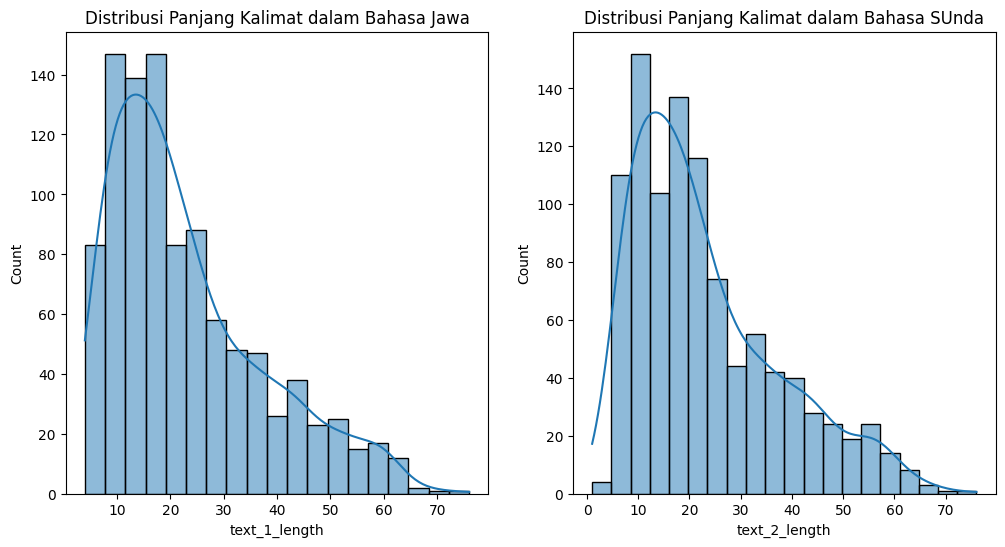

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(jav_sun_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Jawa')

plt.subplot(1,2,2)
sns.histplot(jav_sun_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa SUnda')

plt.show()


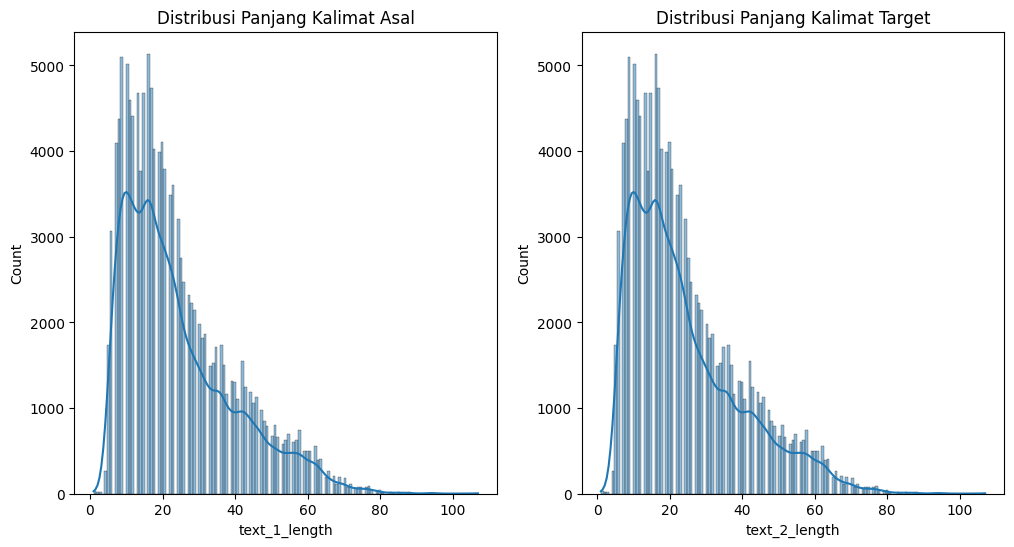

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(nusax_full_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Asal')

plt.subplot(1,2,2)
sns.histplot(nusax_full_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Target')

plt.show()


### Most Common Words

After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [ ]:
# kata kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

print("Kata-kata Paling Umum dalam Bahasa Jawa:")
print(get_most_common_words(jav_sun_df['text_1']))

print("\nKata-kata Paling Umum dalam Bahasa SUnda:")
print(get_most_common_words(jav_sun_df['text_2']))

Kata-kata Paling Umum dalam Bahasa Jawa:
[('sing', 667), ('lan', 555), ('ora', 450), ('karo', 328), ('aku', 302), ('ing', 285), ('ning', 265), ('kanggo', 240), ('mangan', 219), ('iki', 205)]

Kata-kata Paling Umum dalam Bahasa SUnda:
[('nu', 615), ('sareng', 542), ('di', 457), ('teu', 375), ('abdi', 314), ('ka', 247), ('aya', 216), ('anu', 214), ('kanggo', 198), ('ku', 192)]


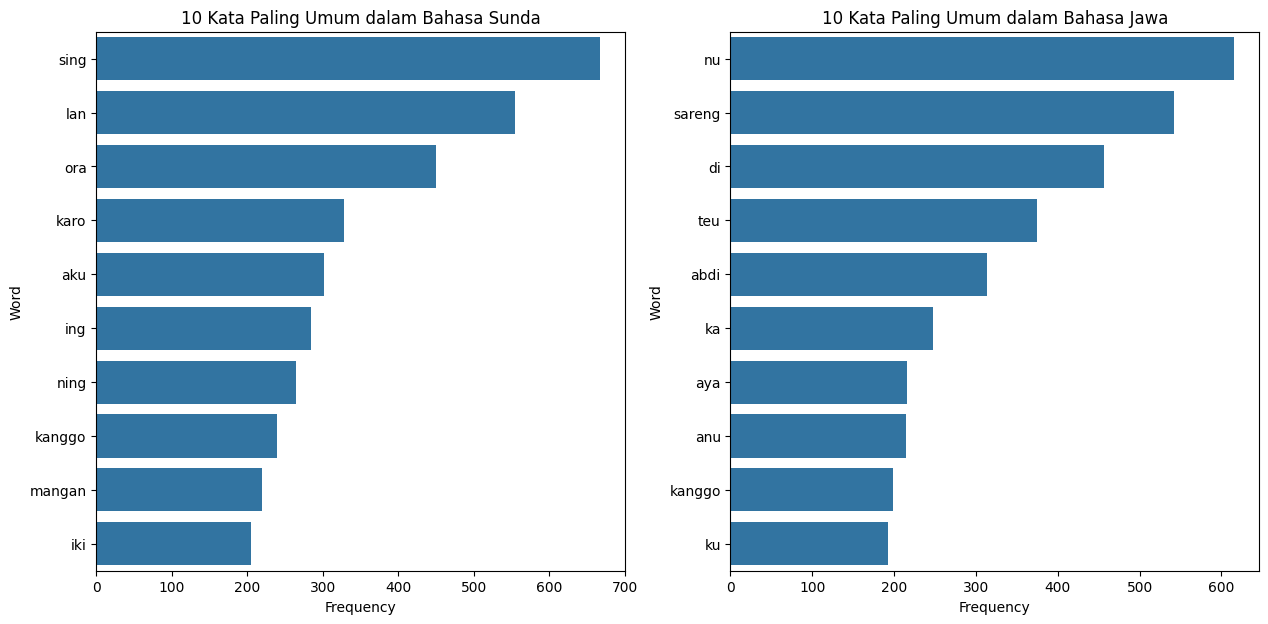

In [ ]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(jav_sun_df['text_1'], 10)
top_eng_words = get_most_common_words(jav_sun_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Jawa')

plt.show()

### N-Grams Analysis

We also can check the most common words using N-Grams function in this below code cell

In [ ]:
def generate_ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Contoh untuk bigram dalam Bahasa Jawa
sun_bigrams = generate_ngrams(" ".join(jav_sun_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Sunda
eng_bigrams = generate_ngrams(" ".join(jav_sun_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

####################


[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

In [ ]:
# Contoh untuk trigram dalam Bahasa Sunda
sun_trigrams = generate_ngrams(" ".join(jav_sun_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk trigram dalam Bahasa Inggris
eng_trigrams = generate_ngrams(" ".join(jav_sun_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

####################


[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

### WordClouds

We can also visualize the most common words in the datasets from each languages using WordClouds library.

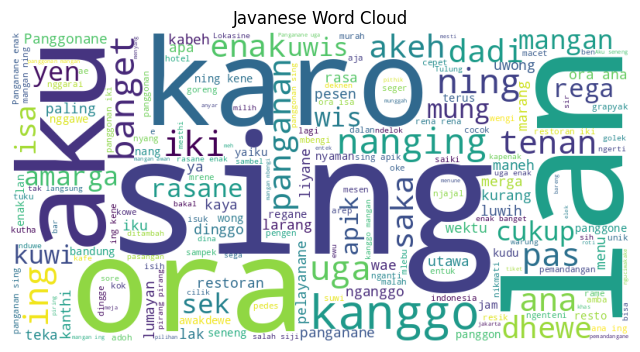

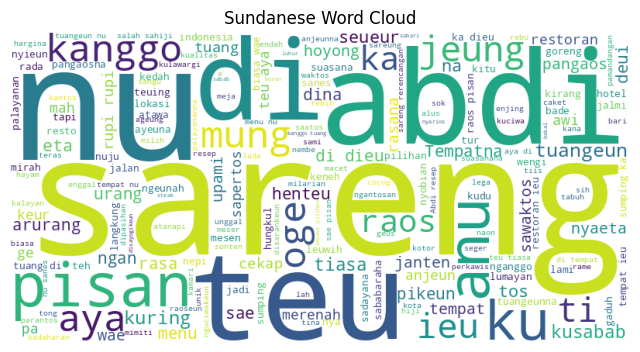

In [ ]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(jav_sun_df['text_1'], 'Javanese Word Cloud')
plot_word_cloud(jav_sun_df['text_2'], 'Sundanese Word Cloud')


# Texts Preprocessing

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text, stopwords_list):
    # Convert text to lower case
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    words = text.split()
    # filtered_words = [word for word in words if word not in stopwords_list]

    # Remove double spaces
    text = ' '.join(
        words
        # filtered_words
        )

    return text

javanese_stopwords = set([
    "is", "the", "and", "to", "a", "of", "it", "in"
])

sundanese_stopwords = set([
    "di", "dan", "yang", "nu", "ka", "ku"
])

# preprocesed_df = sun_eng_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# sun_jav_df['text_1'] = sun_jav_df['text_1'].apply(lambda x: preprocess_text(x, sundanese_stopwords))
# sun_jav_df['text_2'] = sun_jav_df['text_2'].apply(lambda x: preprocess_text(x, javanese_stopwords))

#### Check the Datasets again after text preprocessing

In [ ]:
display(jav_sun_df)

,id,text_1,text_2,text_1_lang,text_2_lang,text_1_length,text_2_length
0,0,Nikmatono cicilan 0% sampek 12 sasi dinggo pes...,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,jav,sun,16,17
1,1,Roti-roti sing disajekne nggarai aku nostalgia...,Kue anu disajikeun ngajantenkeun kuring nostal...,jav,sun,21,23
2,2,Ibu uwis tahu kerja ing grab indonesia,Ibu kantos ngadamel di grab indonesia,jav,sun,7,6
3,3,Paling seneng banget mangan awan ing kene pith...,Pang resepna tuang beubeurangan di dieu hayam ...,jav,sun,58,57
4,4,Pelayanane bis DAMRI apik banget.,Palayanan beus DAMRI sae pisan,jav,sun,5,5
...,...,...,...,...,...,...,...
995,95,Tolong infoake atm nang ndi wae ing semarang s...,Mohon informasikeun atm mana wae di semarang n...,jav,sun,18,17
996,96,Kanca ngrekomendasikake panggonan iki amarga r...,Rerencangan nyarankeun tempat ieu kusabab rasa...,jav,sun,37,37
997,97,"Kaping pisa mara mrene aku nyepelake, pas wekt...","Mimiti kuring kadieu nganggap enteng, sawaktos...",jav,sun,38,38
998,98,Panggonane nyenengake kanggo sing uwis kaluwar...,Tempatna nyenengkeun nya kanggo nu atos berkul...,jav,sun,41,42


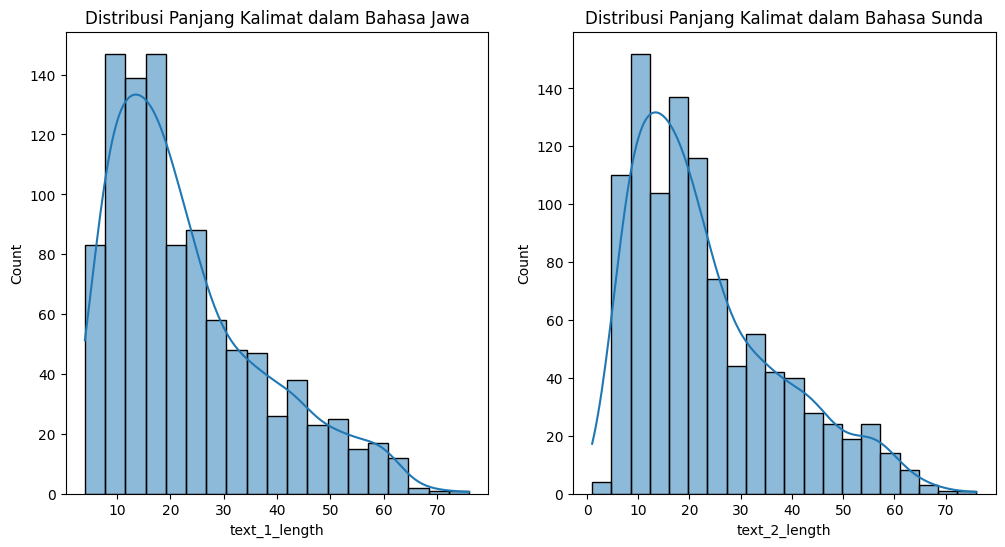

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(jav_sun_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Jawa')

plt.subplot(1,2,2)
sns.histplot(jav_sun_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Sunda')

plt.show()


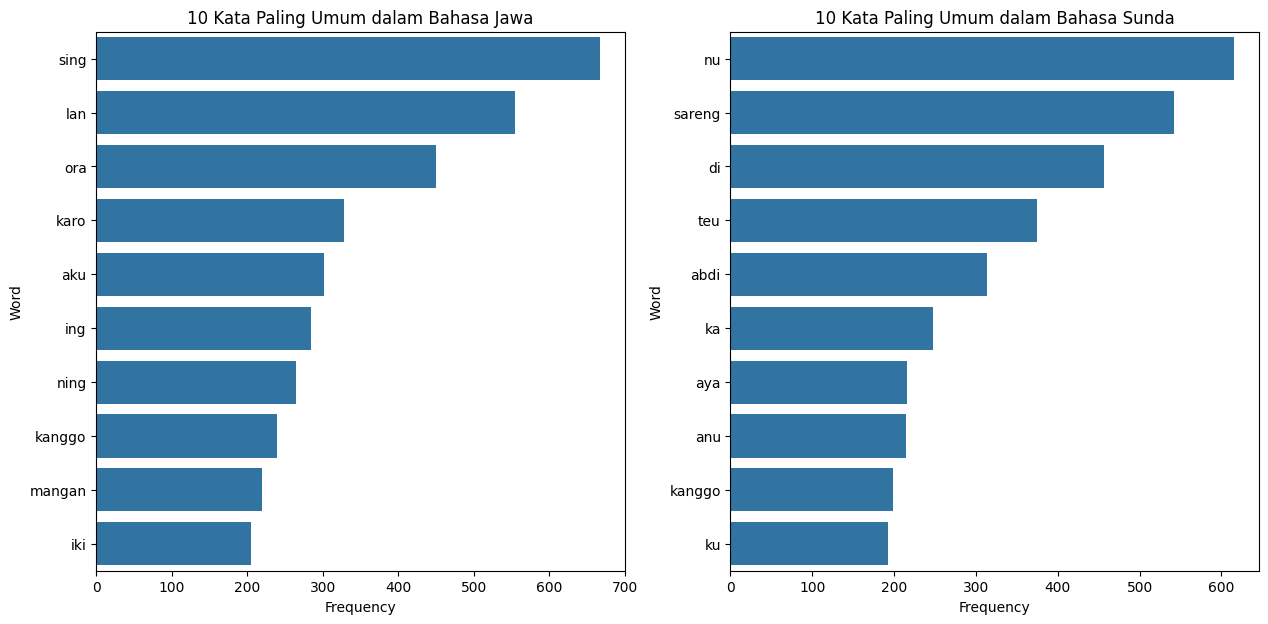

In [ ]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(jav_sun_df['text_1'], 10)
top_eng_words = get_most_common_words(jav_sun_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Jawa')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Sunda')

plt.show()

In [ ]:
print("BIGRAMS")
# Contoh untuk bigram dalam Bahasa Jawa
sun_bigrams = generate_ngrams(" ".join(jav_sun_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Sunda
eng_bigrams = generate_ngrams(" ".join(jav_sun_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

print('#'*25)

print("TRIGRAMS")
# Contoh untuk trigram dalam Bahasa Jawa
sun_trigrams = generate_ngrams(" ".join(jav_sun_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk trigram dalam Bahasa Sunda
eng_trigrams = generate_ngrams(" ".join(jav_sun_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

BIGRAMS


[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

####################


[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

#########################
TRIGRAMS


[('ora ana', 34),
 ('enak lan', 30),
 ('mangan ning', 27),
 ('ora isa', 26),
 ('panganan sing', 24),
 ('ana ing', 24),
 ('lan ora', 21),
 ('ing kene', 20),
 ('sing apik', 20),
 ('sing ora', 20)]

####################


[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

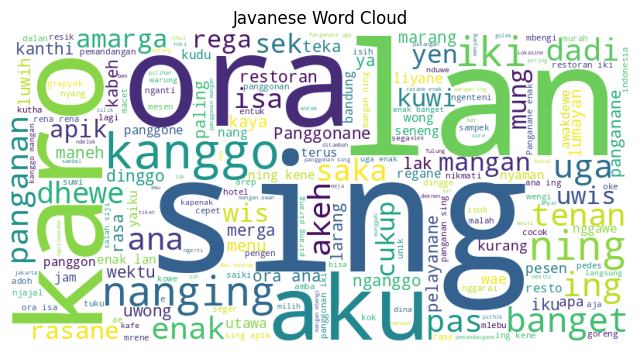

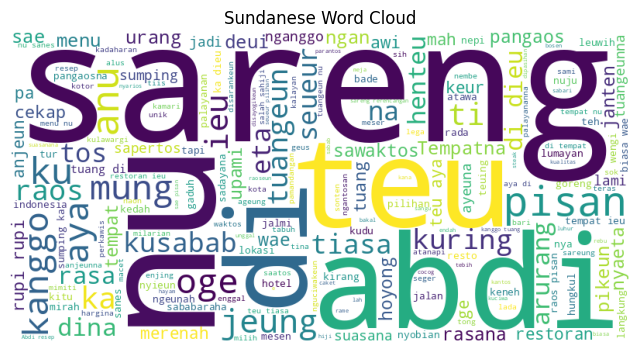

In [ ]:
plot_word_cloud(jav_sun_df['text_1'], 'Javanese Word Cloud')
plot_word_cloud(jav_sun_df['text_2'], 'Sundanese Word Cloud')

# Datasets Preprocessing

In [11]:
nusax_JavSun = DatasetHF.from_pandas(jav_sun_df)

display(nusax_JavSun)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

In [12]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits = nusax_JavSun.train_test_split(test_size=0.2)
train_dataset, valid_test_dataset = splits['train'], splits['test']

splits = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits['train'], splits['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 100
})

In [15]:
checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

source_lang = 'jav'
target_lang = 'sun'
prefix = "Translate Javanese to Sundanese: "

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input (Sundanese) and target (English) separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [ ]:
def preprocess_function(examples):
    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
display(tokenized_nusax_train)
display(tokenized_nusax_test)
display(tokenized_nusax_valid)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [ ]:
tokenized_nusax_train['input_ids'][:1]

[[30355,
  15,
  10318,
  1496,
  15,
  12,
  3068,
  3768,
  15,
  7,
  15,
  10,
  262,
  348,
  18,
  15,
  348,
  880,
  127,
  152,
  15,
  3,
  60,
  5402,
  5,
  445,
  26,
  88,
  40,
  1825,
  4301,
  32,
  3,
  13067,
  157,
  3,
  53,
  197,
  16864,
  3,
  2388,
  53,
  18,
  2388,
  53,
  3,
  21355,
  3478,
  3,
  60,
  7,
  23,
  157,
  10159,
  67,
  1725,
  839,
  3,
  157,
  1468,
  839,
  3,
  29,
  63,
  17815,
  1258,
  1050,
  2131,
  2565,
  152,
  5,
  9144,
  3,
  12204,
  46,
  9,
  4301,
  32,
  3,
  13067,
  157,
  3,
  53,
  5084,
  1744,
  2618,
  15,
  5,
  4266,
  1478,
  15,
  855,
  3,
  4031,
  15,
  7,
  23,
  3304,
  15,
  2131,
  4102,
  106,
  152,
  1227,
  13306,
  2168,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [ ]:
tokenized_nusax_train['attention_mask'][:1]

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [9]:
import evaluate

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


compute metrics function

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Initialize result dictionary
    result = {}

    # Calculate accuracy
    total = len(decoded_labels)
    correct = sum(pred == label[0] for pred, label in zip(decoded_preds, decoded_labels))
    accuracy = correct / total
    result["accuracy"] = accuracy

    # Compute sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # Compute METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]

    # Compute BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}

    return result


In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model_path = "/content/drive/MyDrive/Models/T5-small-CC100&NusaX-SU-JV-02" # "/content/drive/MyDrive/Models/T5-small-CC100-SU-JV"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

training arguments

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="T5_NusaX_Jav_Sun_checkpoints",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=200,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Bleu,Meteor,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
1,No log,1.116387,0.000000,0.216800,0.071300,0.848200,0.801000,0.823700,18.850000
2,No log,1.063994,0.000000,0.215700,0.074100,0.848800,0.800900,0.823900,18.860000
3,No log,1.029507,0.000000,0.192800,0.069300,0.845900,0.797700,0.820900,18.870000
4,No log,1.003127,0.000000,0.180400,0.070100,0.845400,0.794800,0.819100,18.830000
5,No log,0.979311,0.000000,0.169800,0.073000,0.844700,0.794600,0.818700,18.830000
6,No log,0.959502,0.000000,0.162800,0.070900,0.843500,0.793300,0.817400,18.830000
7,No log,0.939887,0.000000,0.168200,0.070500,0.844300,0.793600,0.817900,18.830000
8,No log,0.923233,0.000000,0.161200,0.069800,0.844100,0.793800,0.817900,18.860000
9,No log,0.907706,0.000000,0.168800,0.071000,0.843400,0.793800,0.817600,18.860000
10,1.066800,0.894433,0.000000,0.168100,0.072300,0.845800,0.795400,0.819600,18.860000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) 

In [ ]:
model_name = "/content/drive/MyDrive/Models/T5-small-CC100&NusaX-SunJav-PT"
trainer.save_model(model_name)

# Predict Evaluate

### Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from English to French, you should prefix your input as shown below:

In [8]:
from transformers import pipeline

model_name = "/content/drive/MyDrive/Models/T5-small-CC100&NusaX-SunJav-PT"

source = "Translate Javanese to Sundanese: Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui."
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': 'Abdi teu ngagaduhan patarosan teu teu aya ngalaman masalah teu aya hubungana sareng produk Traveloka, tong ragu ngahubungi kami teui.'}]

In [22]:
source = "Translate Javanese to Sundanese: Sopo iki?"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'translation_text': 'Sopo ieu?'}]

In [23]:
source = "Translate Sundanese to Javanese: Saha aing?"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'translation_text': ''}]

In [24]:
model_name = "/content/drive/MyDrive/Models/T5-small-CC100&NusaX-SU-JV-02/"

source = "Translate Sundanese to Javanese: Saha urang?"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': 'Übersetzen Sie sich ins javanische: Saha urang?'}]

In [16]:

def predict_evaluate(data):
    try:
        sources = data['text_1']
        targets = data['text_2']

        predictions = [translator(prefix + source)[0]['translation_text'] for source in sources]

        # Initialize lists to store results
        predicts, accuracies, bleus, meteors, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            # Calculate accuracy for each prediction
            accuracies.append(int(prediction == target))

            # Compute sacreBLEU
            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            # Compute METEOR
            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            # Compute BERTScore
            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="en")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        # Return a dictionary with lists as values
        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            "accuracy": accuracies,  # Now a list of accuracies
            "bleu": bleus,
            "meteor": meteors,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None

# Assuming test_dataset is correctly defined
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)



Map:   0%|          | 0/100 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(['text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length',], axis=1))

,id,input,predict,target,accuracy,bleu,meteor,bertscore_precision,bertscore_recall,bertscore_f1
0,356,"Asli tenan indihome nemen tenan saiki, apa gun...","Asli pisan indihome nepi pisan ayeuna, aya gun...","Indihome ayeuna parah pisan, naon gunana mayar...",0,4.444588,0.250000,[0.8867315053939819],[0.8749159574508667],[0.8807840943336487]
1,299,Aku tuku werna-werna roti. Piliane akeh nangin...,Abdi tiasa tuangeunna roti. Pangaosna seueur n...,Abdi meser rupi-rupi macem roti. Pilihanna seu...,0,30.958266,0.555662,[0.8990738391876221],[0.896233081817627],[0.897651195526123]
2,187,Mangkel udu amarga kowe. Nanging persis dikala...,Mangkel udu kusabab teuing. Ngan persis dikala...,Keuheul lain kusabab anjeun. Mung persis diele...,0,8.968622,0.332817,[0.8632205128669739],[0.8510128259658813],[0.857073187828064]
3,160,Lokasine ana ing dalam utama dadi gampang dhew...,Lokasina aya di dalam utama kusabab kanggo tem...,Perenahna aya di jalan utama panginten ngagamp...,0,28.075668,0.518214,[0.9080944657325745],[0.8772562742233276],[0.8924090266227722]
4,276,Panganane lumayan enak-enak ing hawa anyes lan...,Tuangeunna lumayan raos-raos di hawa anyes sar...,Tuangeunna lumayan raos-raos dina udara tiis s...,0,37.518405,0.616638,[0.9064651727676392],[0.893911600112915],[0.900144636631012]
...,...,...,...,...,...,...,...,...,...,...
95,323,"Kahanan sawah lan nggunung, ana wine cellare. ...","Kahanan sawah sareng ngagunung, aya wine cella...","Suasana sawah sareng gunung, aya wine cellarna...",0,9.389703,0.489739,[0.8976665735244751],[0.8868983387947083],[0.8922499418258667]
96,277,Tulung golekake alamat uwong iki. Bakal aku ja...,Tulung golekakeun alamat sareng ieu. Bakal abd...,Tulung pilarian alamat jalmi ieu. Bade abdi aj...,0,4.935861,0.275556,[0.859452486038208],[0.8612130880355835],[0.8603318929672241]
97,366,Rasa nikmat dipadu karo sambele. Daginge empuk...,Rasa nikmat dipadu sareng sareng nyaeta. Dagin...,Rasa raos dipadu sareng sambelna. Daging hipu....,0,6.804344,0.342857,[0.8918124437332153],[0.8937243819236755],[0.8927673697471619]
98,392,"Panganane enak: pithik goreng, oseng terong, s...","Tuangeunna raos: pithik goreng, oseng terong, ...","Tuangeunna raos: hayam goreng, tumis terong, s...",0,31.967153,0.608466,[0.9430276155471802],[0.942171573638916],[0.9425994157791138]


In [18]:
display(predict_eval_df[:1]['predict'])
display(predict_eval_df[:1]['target'])

0    Asli pisan indihome nepi pisan ayeuna, aya gun...
Name: predict, dtype: object

0    Indihome ayeuna parah pisan, naon gunana mayar...
Name: target, dtype: object

In [19]:
predict_eval_df['bleu'].mean()

17.213527512842408

In [20]:
predict_eval_df['meteor'].mean()

0.44217599914008077

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models